In [1]:
include("utils/preprocessing.jl")
include("utils/model_evaluation.jl")
include("utils/data_loader.jl")
include("utils/visualization.jl")
include("utils/ml1_utils.jl")

evaluateAndPrintMetricsRanking (generic function with 1 method)

In [2]:
# import Pkg;
# Pkg.add("Random")
# Pkg.add("MLBase")
# Pkg.add("JLD")
# Pkg.add("ScikitLearn")

using Random
Random.seed!(123)

using ScikitLearn
using JLD

## DESCRIPTION OF APPROACH ##

##### LOAD THE DATA #####

In [3]:
data = DataLoader.load_data("dataset\\star_classification.csv");

##### (OPTIONAL) REDUCE THE DATASET #####

In [4]:
function reduce_data(dataset::Matrix, percentage_to_keep::Float64)
    # Extract data and targets from the dataset
    data = dataset[:, 1:end-1]
    targets = dataset[:, 14] 
    
    unique_classes = unique(targets)
    reduced_data = Matrix{Float64}(undef, 0, size(data, 2))
    reduced_targets = Vector{Float64}()

    for class in unique_classes
        # Get the data and targets for this class
        class_data = data[targets .== class, :]
        class_targets = targets[targets .== class]

        # Calculate the number of rows to keep
        num_rows_to_keep = Int(ceil(size(class_data, 1) * percentage_to_keep))

        # Randomly select the subset of rows
        indices = randperm(size(class_data, 1))[1:num_rows_to_keep]
        subset_class_data = class_data[indices, :]
        subset_class_targets = class_targets[indices]

        # Append the reduced data and targets for this class to the overall reduced data and targets
        reduced_data = vcat(reduced_data, subset_class_data)
        reduced_targets = vcat(reduced_targets, subset_class_targets)
    end

    # Combine reduced data and targets
    reduced_dataset = hcat(reduced_data, reduced_targets)

    return reduced_dataset
end


reduced_data = reduce_data(data, 0.15)

#= using StatsBase

# Extract the class column from the reduced dataset
classes = reduced_data[2:end, 14]

# Count the number of rows in each class
class_counts = countmap(classes)

# Print the counts
for (class, count) in class_counts
    println("Class $class: $count rows")
end =#

15003×18 Matrix{Any}:
                    "obj_ID"  …       "plate"       "MJD"  "class"
 1237663917871596800              3656         55241       "GALAXY"
 1237654381974127616              6395         56354       "GALAXY"
 1237660763222443008              4481         55630       "GALAXY"
 1237660962397749504              1267         52932       "GALAXY"
 1237679322864222464          …   9315         57713       "GALAXY"
 1237667781742232320              5305         55984       "GALAXY"
 1237657589784772864              1016         52759       "GALAXY"
 1237665127995867904             10452         58138       "GALAXY"
 1237648704587432448              4043         55630       "GALAXY"
 1237664877805962240          …  10451         58141       "GALAXY"
 1237680504510678016              7136         56570       "GALAXY"
 1237664817671241728              2034         53466       "GALAXY"
                   ⋮          ⋱      ⋮                     
 1237646796521866496              7

##### PREPROCESSING THE DATASET #####

In [5]:
# preprocess_data(dataset, holdOut ratio, normalization method, balancing_dataset, features)
train_inputs, train_targets, test_inputs, test_targets = Preprocessing.preprocess_data(data, 0.8, "minmax", false, [4,5,6,7,8,15]);

"""    This function does the following:
        - Balance the data using the undersampling method if chosen to do so
        - Parse the data: chosing the correct columns for inputs and targets (Shouldn't this be done before balancing??)
        - Splits the data into training and testing using holdOut method
        - Normalize the inputs  ------> zeromean method still to be implemented!!!!
"""

# Print first input and target
println("First input: ", train_inputs[1, :])
println("First target: ", train_targets[1, :])

Train_inputs before normalization: Float32[21.74464, 21.72516, 21.59273, 21.15863, 21.27599, 0.8867747]
First input: Float32[0.50357157, 0.63839275, 0.66229284, 0.5404958, 0.6213335, 0.12699394]
First target: Any["GALAXY"]


## Testing hyperparameters for each model ##

In [6]:
@sk_import neural_network: MLPClassifier;
@sk_import svm: SVC;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;
@sk_import ensemble: RandomForestClassifier;
@sk_import ensemble: StackingClassifier;
@sk_import metrics: accuracy_score;

In [7]:
"""
Setting indices for the k-fold cross-validation
    we are about to do with the different models
"""
N=size(train_inputs,1)
k = 5 # number of folds
kFoldIndices = crossvalidation(N, k);

##### DECISION TREE #####

In [8]:
# Define an array of hyperparameter dictionaries for the Decision Tree model
dtree_hyperparameters_array = [
    Dict("max_depth" => 3),
    Dict("max_depth" => 5),
    Dict("max_depth" => 10),
    Dict("max_depth" => 20),
    Dict("max_depth" => 50),
    Dict("max_depth" => 100) # Deeper trees can capture more detail but risk overfitting
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:DecisionTree,dtree_hyperparameters_array, train_inputs, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6

----- acc -----
Set of hyperparameters 3 -> mean: 0.969 Std. Dev.: 0.003
Set of hyperparameters 2 -> mean: 0.962 Std. Dev.: 0.004
Set of hyperparameters 4 -> mean: 0.962 Std. Dev.: 0.003
Set of hyperparameters 5 -> mean: 0.962 Std. Dev.: 0.003
Set of hyperparameters 6 -> mean: 0.962 Std. Dev.: 0.003
Set of hyperparameters 1 -> mean: 0.949 Std. Dev.: 0.004

----- sensitivity -----
Set of hyperparameters 3 -> mean: 0.969 Std. Dev.: 0.003
Set of hyperparameters 2 -> mean: 0.962 Std. Dev.: 0.004
Set of hyperparameters 4 -> mean: 0.962 Std. Dev.: 0.003
Set of hyperparameters 5 -> mean: 0.962 Std. Dev.: 0.003
Set of hyperparameters 6 -> mean: 0.962 Std. Dev.: 0.003
Set of hyperparameters 1 -> mean: 0.949 Std. Dev.: 0.004

----- specificity -----
Set of hyperpar

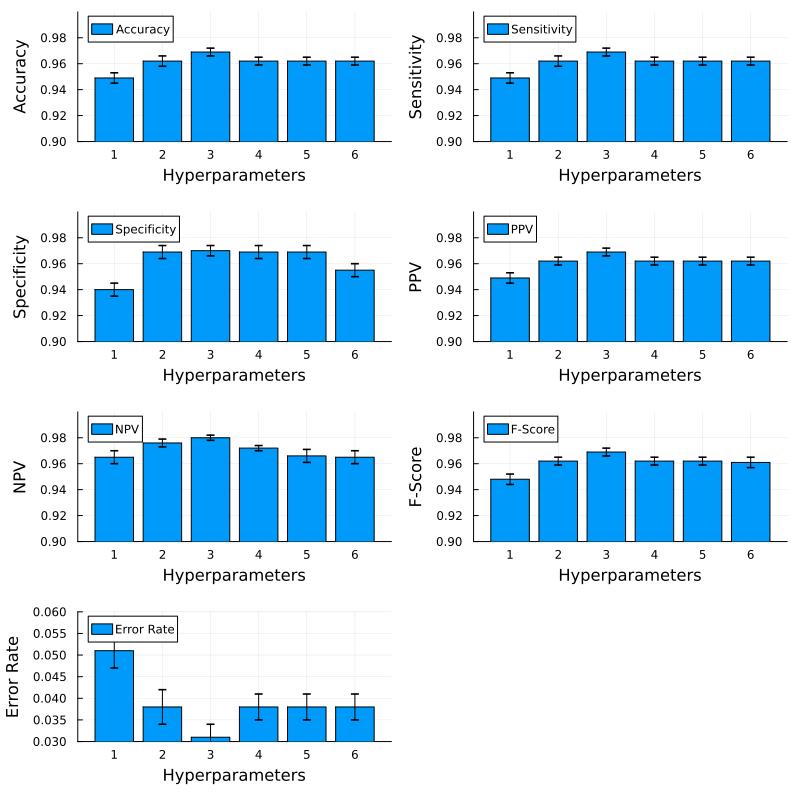

In [23]:
using Plots

# Data
hyperparameters = [3, 2, 4, 5, 6, 1]
acc_mean = [0.969, 0.962, 0.962, 0.962, 0.962, 0.949]
acc_std = [0.003, 0.004, 0.003, 0.003, 0.003, 0.004]

sensitivity_mean = [0.969, 0.962, 0.962, 0.962, 0.962, 0.949]
sensitivity_std = [0.003, 0.004, 0.003, 0.003, 0.003, 0.004]

specificity_mean = [0.97, 0.969, 0.969, 0.969, 0.955, 0.94]
specificity_std = [0.004, 0.005, 0.005, 0.005, 0.005, 0.005]

ppv_mean = [0.969, 0.962, 0.962, 0.962, 0.962, 0.949]
ppv_std = [0.003, 0.003, 0.003, 0.003, 0.003, 0.004]

npv_mean = [0.98, 0.976, 0.972, 0.966, 0.965, 0.965]
npv_std = [0.002, 0.003, 0.002, 0.005, 0.005, 0.005]

f_score_mean = [0.969, 0.962, 0.962, 0.962, 0.961, 0.948]
f_score_std = [0.003, 0.003, 0.003, 0.003, 0.004, 0.004]

err_rate_mean = [0.031, 0.038, 0.038, 0.038, 0.038, 0.051]
err_rate_std = [0.003, 0.004, 0.003, 0.003, 0.003, 0.004]

# Plotting
plot_metrics(metric_name, mean_values, std_values) = bar(hyperparameters, mean_values, yerr=std_values, xlabel="Hyperparameters", ylabel=metric_name, label=metric_name, legend=:topleft)

# Create subplots
p = plot(
    plot_metrics("Accuracy", acc_mean, acc_std),
    plot_metrics("Sensitivity", sensitivity_mean, sensitivity_std),
    plot_metrics("Specificity", specificity_mean, specificity_std),
    plot_metrics("PPV", ppv_mean, ppv_std),
    plot_metrics("NPV", npv_mean, npv_std),
    plot_metrics("F-Score", f_score_mean, f_score_std),
    plot_metrics("Error Rate", err_rate_mean, err_rate_std),
    layout=(4, 2), size=(800, 800)
)

# Adjust y-axis scale for "Error Rate" subplot
ylims!(p[end], (0.03, 0.06))  # Adjust the ylims as needed for the "Error Rate" subplot

# Adjust y-axis scale for other subplots
for i in 1:length(p)-1
    ylims!(p[i], (0.9, 1.0))
end

display(p)


##### kNN #####

In [9]:
# Define an array of hyperparameter dictionaries for the kNN model
knn_hyperparameters_array = [
    Dict("n_neighbors" => 5),
    Dict("n_neighbors" => 10),
    Dict("n_neighbors" => 15),
    Dict("n_neighbors" => 20),
    Dict("n_neighbors" => 50),
    Dict("n_neighbors" => 100) # Large neighborhoods, smooths out predictions
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:kNN,knn_hyperparameters_array, train_inputs, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6

----- acc -----
Set of hyperparameters 1 -> mean: 0.951 Std. Dev.: 0.002
Set of hyperparameters 2 -> mean: 0.947 Std. Dev.: 0.003
Set of hyperparameters 3 -> mean: 0.944 Std. Dev.: 0.004
Set of hyperparameters 4 -> mean: 0.94 Std. Dev.: 0.003
Set of hyperparameters 5 -> mean: 0.923 Std. Dev.: 0.004
Set of hyperparameters 6 -> mean: 0.9 Std. Dev.: 0.002

----- sensitivity -----
Set of hyperparameters 1 -> mean: 0.951 Std. Dev.: 0.002
Set of hyperparameters 2 -> mean: 0.947 Std. Dev.: 0.003
Set of hyperparameters 3 -> mean: 0.944 Std. Dev.: 0.004
Set of hyperparameters 4 -> mean: 0.94 Std. Dev.: 0.003
Set of hyperparameters 5 -> mean: 0.923 Std. Dev.: 0.004
Set of hyperparameters 6 -> mean: 0.9 Std. Dev.: 0.002

----- specificity -----
Set of hyperparameter

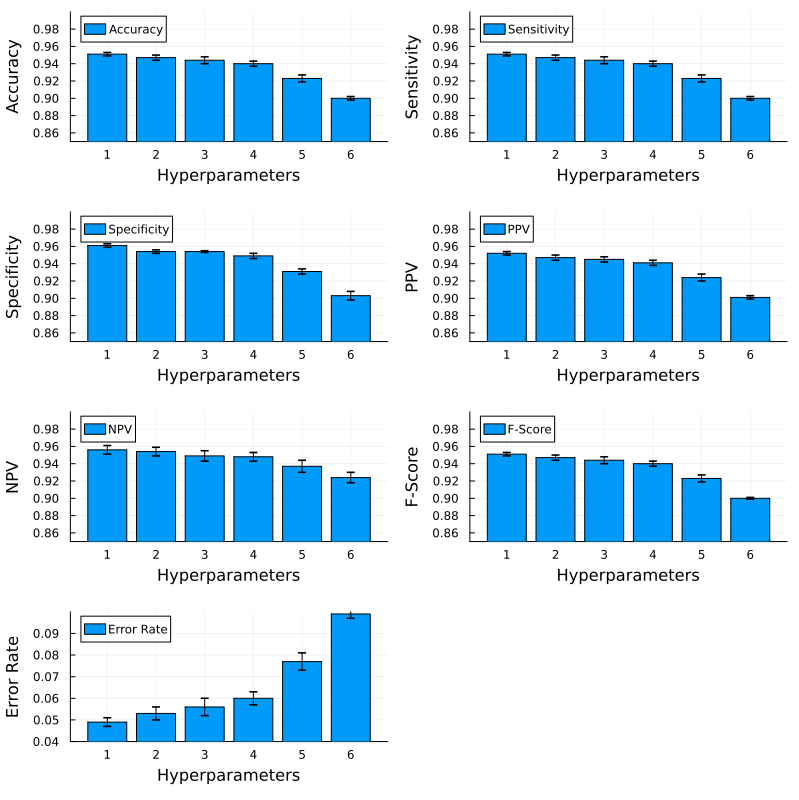

In [28]:
using Plots

# Data
hyperparameters = [1, 2, 3, 4, 5, 6]
acc_mean = [0.951, 0.947, 0.944, 0.94, 0.923, 0.9]
acc_std = [0.002, 0.003, 0.004, 0.003, 0.004, 0.002]

sensitivity_mean = [0.951, 0.947, 0.944, 0.94, 0.923, 0.9]
sensitivity_std = [0.002, 0.003, 0.004, 0.003, 0.004, 0.002]

specificity_mean = [0.961, 0.954, 0.954, 0.949, 0.931, 0.903]
specificity_std = [0.002, 0.002, 0.001, 0.003, 0.003, 0.005]

ppv_mean = [0.952, 0.947, 0.945, 0.941, 0.924, 0.901]
ppv_std = [0.002, 0.003, 0.003, 0.003, 0.004, 0.002]

npv_mean = [0.956, 0.954, 0.949, 0.948, 0.937, 0.924]
npv_std = [0.005, 0.005, 0.006, 0.005, 0.007, 0.006]

f_score_mean = [0.951, 0.947, 0.944, 0.94, 0.923, 0.9]
f_score_std = [0.002, 0.003, 0.004, 0.003, 0.004, 0.001]

err_rate_mean = [0.049, 0.053, 0.056, 0.06, 0.077, 0.099]
err_rate_std = [0.002, 0.003, 0.004, 0.003, 0.004, 0.002]

# Plotting
plot_metrics(metric_name, mean_values, std_values) = bar(hyperparameters, mean_values, yerr=std_values, xlabel="Hyperparameters", ylabel=metric_name, label=metric_name, legend=:topleft)

# Create subplots
p = plot(
    plot_metrics("Accuracy", acc_mean, acc_std),
    plot_metrics("Sensitivity", sensitivity_mean, sensitivity_std),
    plot_metrics("Specificity", specificity_mean, specificity_std),
    plot_metrics("PPV", ppv_mean, ppv_std),
    plot_metrics("NPV", npv_mean, npv_std),
    plot_metrics("F-Score", f_score_mean, f_score_std),
    plot_metrics("Error Rate", err_rate_mean, err_rate_std),
    layout=(4, 2), size=(800, 800)
)

# Adjust y-axis scale for "Error Rate" subplot
ylims!(p[end], (0.04, 0.1))  # Adjust the ylims as needed for the "Error Rate" subplot

# Adjust y-axis scale for other subplots
for i in 1:length(p)-1
    ylims!(p[i], (0.85, 1.0))
end

display(p)


##### SVM #####

In [10]:
svm_hyperparameters_array = [
    # Uses 'rbf' kernel, medium complexity with C=1.0, default polynomial degree, 'scale' for gamma 
    Dict("kernel" => "rbf", "degree" => 3, "C" => 1.0, "gamma" => "scale"),
    
    # Same 'rbf' kernel, increased penalty (C=10.0) for larger-margin separation, 'auto' gamma adjusts based on features
    Dict("kernel" => "rbf", "degree" => 3, "C" => 10.0, "gamma" => "auto"),
    
    # Same 'rbf' kernel, lower penalty (C=0.1) for a softer-margin, 'scale' gamma is default scaling
    Dict("kernel" => "rbf", "degree" => 3, "C" => 0.1, "gamma" => "scale"),

    # 'linear' kernel, suitable for less complex data
    Dict("kernel" => "linear", "degree" => 5,  "C" => 0.1, "gamma" => "auto"),
    
    # 'linear' kernel, not affected by 'degree' or 'gamma', with C=1.0 indicating a balance between margin and misclassification
    Dict("kernel" => "linear", "degree" => 3, "C" => 1.0, "gamma" => "auto"),

    # 'linear' kernel with a higher penalty, stricter margin
    Dict("kernel" => "linear", "degree" => 7, "C" => 10.0, "gamma" => "scale"),
    
    # 'poly' kernel, polynomial degree is set twice by mistake, should only be 'degree' => 3, 'scale' gamma defaults to feature scale
    Dict("kernel" => "poly", "degree" => 3, "C" => 1.0, "gamma" => "scale"),
    
    # 'poly' kernel, increased polynomial degree (5) for higher model complexity, 'auto' gamma may overfit with high dimension
    Dict("kernel" => "poly", "degree" => 5, "C" => 1.0, "gamma" => "auto")
]


# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:SVM, svm_hyperparameters_array, train_inputs, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6
Training with set of hyperparameters 7
Training with set of hyperparameters 8

----- acc -----
Set of hyperparameters 1 -> mean: 0.951 Std. Dev.: 0.002
Set of hyperparameters 7 -> mean: 0.946 Std. Dev.: 0.005
Set of hyperparameters 2 -> mean: 0.94 Std. Dev.: 0.003
Set of hyperparameters 6 -> mean: 0.938 Std. Dev.: 0.003
Set of hyperparameters 3 -> mean: 0.905 Std. Dev.: 0.004
Set of hyperparameters 5 -> mean: 0.898 Std. Dev.: 0.004
Set of hyperparameters 4 -> mean: 0.806 Std. Dev.: 0.005
Set of hyperparameters 8 -> mean: 0.616 Std. Dev.: 0.008

----- sensitivity -----
Set of hyperparameters 1 -> mean: 0.951 Std. Dev.: 0.002
Set of hyperparameters 7 -> mean: 0.946 Std. Dev.: 0.005
Set of hyperparameters 2 -> mean: 0.94 Std. Dev.: 0.003
Set of hyperparameter

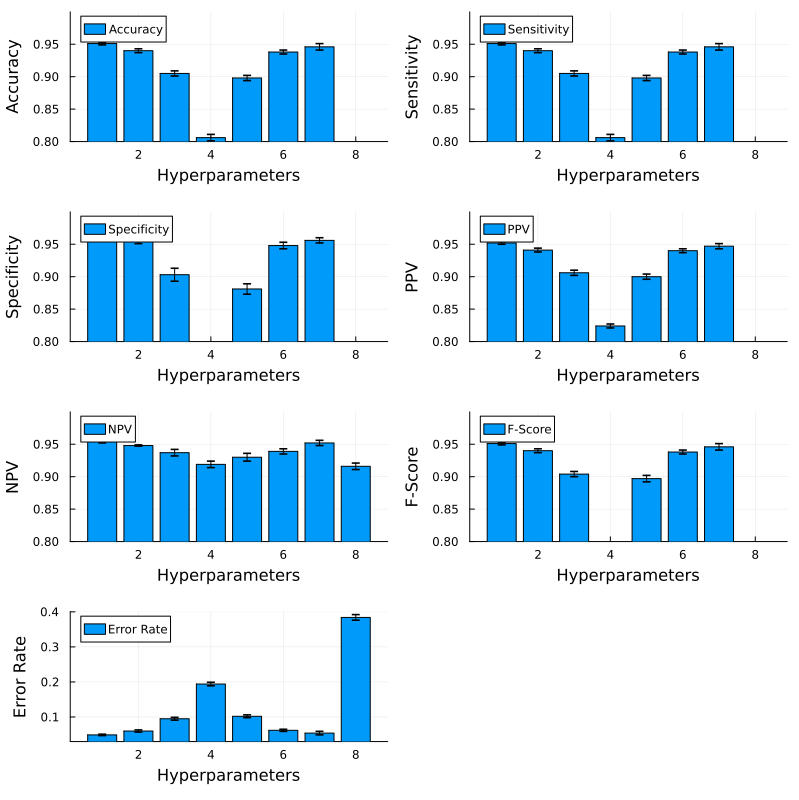

In [25]:
using Plots

# Data
hyperparameters = [1, 7, 2, 6, 3, 5, 4, 8]
acc_mean = [0.951, 0.946, 0.94, 0.938, 0.905, 0.898, 0.806, 0.616]
acc_std = [0.002, 0.005, 0.003, 0.003, 0.004, 0.004, 0.005, 0.008]

sensitivity_mean = [0.951, 0.946, 0.94, 0.938, 0.905, 0.898, 0.806, 0.616]
sensitivity_std = [0.002, 0.005, 0.003, 0.003, 0.004, 0.004, 0.005, 0.008]

specificity_mean = [0.961, 0.956, 0.955, 0.948, 0.903, 0.881, 0.733, 0.431]
specificity_std = [0.003, 0.004, 0.004, 0.005, 0.01, 0.008, 0.005, 0.01]

ppv_mean = [0.952, 0.947, 0.941, 0.94, 0.906, 0.9, 0.824, 0.765]
ppv_std = [0.002, 0.004, 0.003, 0.003, 0.004, 0.004, 0.003, 0.001]

npv_mean = [0.955, 0.952, 0.948, 0.939, 0.937, 0.93, 0.919, 0.916]
npv_std = [0.003, 0.004, 0.001, 0.004, 0.005, 0.006, 0.005, 0.005]

f_score_mean = [0.951, 0.946, 0.94, 0.938, 0.904, 0.897, 0.78, 0.486]
f_score_std = [0.002, 0.005, 0.003, 0.003, 0.004, 0.005, 0.006, 0.009]

err_rate_mean = [0.049, 0.054, 0.06, 0.062, 0.095, 0.102, 0.194, 0.384]
err_rate_std = [0.002, 0.005, 0.003, 0.003, 0.004, 0.004, 0.005, 0.008]

# Plotting
plot_metrics(metric_name, mean_values, std_values) = bar(hyperparameters, mean_values, yerr=std_values, xlabel="Hyperparameters", ylabel=metric_name, label=metric_name, legend=:topleft)

# Create subplots
p = plot(
    plot_metrics("Accuracy", acc_mean, acc_std),
    plot_metrics("Sensitivity", sensitivity_mean, sensitivity_std),
    plot_metrics("Specificity", specificity_mean, specificity_std),
    plot_metrics("PPV", ppv_mean, ppv_std),
    plot_metrics("NPV", npv_mean, npv_std),
    plot_metrics("F-Score", f_score_mean, f_score_std),
    plot_metrics("Error Rate", err_rate_mean, err_rate_std),
    layout=(4, 2), size=(800, 800)
)

# Adjust y-axis scale for "Error Rate" subplot
ylims!(p[end], (0.03, 0.4))  # Adjust the ylims as needed for the "Error Rate" subplot

# Adjust y-axis scale for other subplots
for i in 1:length(p)-1
    ylims!(p[i], (0.8, 1.0))
end

display(p)

##### ANN #####

In [11]:
# Define an array of hyperparameter dictionaries for the ANN model
ann_hyperparameters_array = [
    # Two-layer architecture, moderate neurons
    Dict("architecture" => [50, 30], "activation" => "relu", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer architecture, fewer neurons
    Dict("architecture" => [30], "activation" => "relu", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # Two-layer, different activation function
    Dict("architecture" => [50, 30], "activation" => "tanh", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer, lower learning rate
    Dict("architecture" => [30], "activation" => "relu", "learning_rate" => 0.001, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 2000, "repetitionsTraining" => 10),

    # Two-layer, higher learning rate
    Dict("architecture" => [50, 30], "activation" => "relu", "learning_rate" => 0.05, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer, logistic activation
    Dict("architecture" => [30], "activation" => "logistic", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # Two-layer, more neurons, different activation
    Dict("architecture" => [70, 40], "activation" => "tanh", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer, more neurons
    Dict("architecture" => [50], "activation" => "relu", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10)
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:ANN, ann_hyperparameters_array, train_inputs, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6
Training with set of hyperparameters 7
Training with set of hyperparameters 8

----- acc -----
Set of hyperparameters 7 -> mean: 0.971 Std. Dev.: 0.003
Set of hyperparameters 5 -> mean: 0.97 Std. Dev.: 0.003
Set of hyperparameters 1 -> mean: 0.97 Std. Dev.: 0.003
Set of hyperparameters 3 -> mean: 0.97 Std. Dev.: 0.003
Set of hyperparameters 8 -> mean: 0.969 Std. Dev.: 0.003
Set of hyperparameters 2 -> mean: 0.969 Std. Dev.: 0.003
Set of hyperparameters 6 -> mean: 0.968 Std. Dev.: 0.002
Set of hyperparameters 4 -> mean: 0.967 Std. Dev.: 0.002

----- sensitivity -----
Set of hyperparameters 7 -> mean: 0.971 Std. Dev.: 0.003
Set of hyperparameters 5 -> mean: 0.97 Std. Dev.: 0.003
Set of hyperparameters 1 -> mean: 0.97 Std. Dev.: 0.003
Set of hyperparameters 3

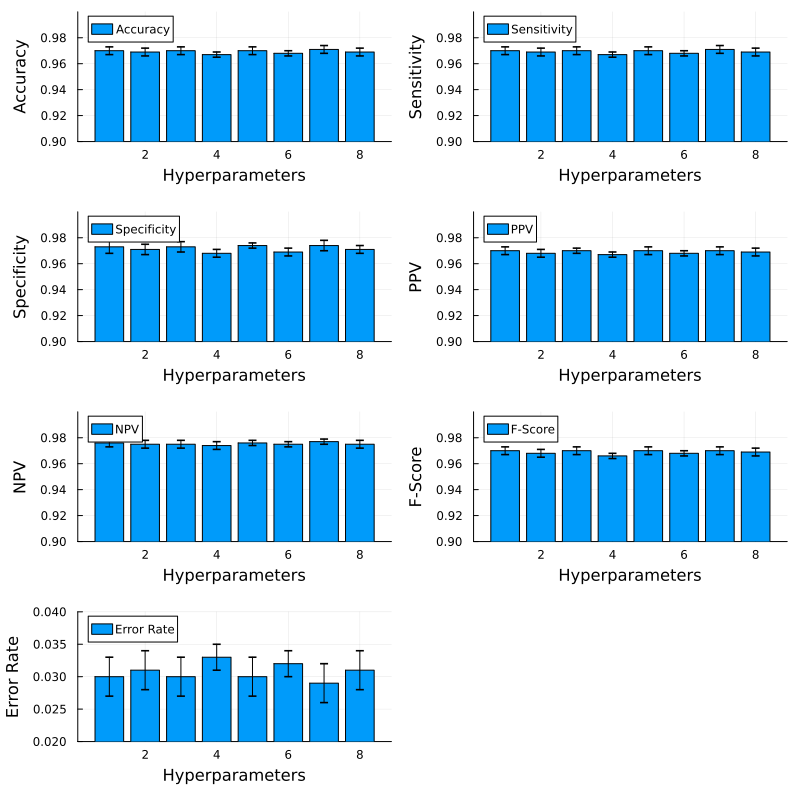

In [27]:
using Plots

# Data
hyperparameters = [7, 5, 1, 3, 8, 2, 6, 4]
acc_mean = [0.971, 0.97, 0.97, 0.97, 0.969, 0.969, 0.968, 0.967]
acc_std = [0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002]

sensitivity_mean = [0.971, 0.97, 0.97, 0.97, 0.969, 0.969, 0.968, 0.967]
sensitivity_std = [0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002]

specificity_mean = [0.974, 0.974, 0.973, 0.973, 0.971, 0.971, 0.969, 0.968]
specificity_std = [0.004, 0.002, 0.005, 0.004, 0.003, 0.004, 0.003, 0.003]

ppv_mean = [0.97, 0.97, 0.97, 0.97, 0.969, 0.968, 0.968, 0.967]
ppv_std = [0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.002, 0.002]

npv_mean = [0.977, 0.976, 0.976, 0.975, 0.975, 0.975, 0.975, 0.974]
npv_std = [0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.002, 0.003]

f_score_mean = [0.97, 0.97, 0.97, 0.97, 0.969, 0.968, 0.968, 0.966]
f_score_std = [0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002]

err_rate_mean = [0.029, 0.03, 0.03, 0.03, 0.031, 0.031, 0.032, 0.033]
err_rate_std = [0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002]

# Plotting
plot_metrics(metric_name, mean_values, std_values) = bar(hyperparameters, mean_values, yerr=std_values, xlabel="Hyperparameters", ylabel=metric_name, label=metric_name, legend=:topleft)

# Create subplots
p = plot(
    plot_metrics("Accuracy", acc_mean, acc_std),
    plot_metrics("Sensitivity", sensitivity_mean, sensitivity_std),
    plot_metrics("Specificity", specificity_mean, specificity_std),
    plot_metrics("PPV", ppv_mean, ppv_std),
    plot_metrics("NPV", npv_mean, npv_std),
    plot_metrics("F-Score", f_score_mean, f_score_std),
    plot_metrics("Error Rate", err_rate_mean, err_rate_std),
    layout=(4, 2), size=(800, 800)
)

# Adjust y-axis scale for "Error Rate" subplot
ylims!(p[end], (0.02, 0.04))  # Adjust the ylims as needed for the "Error Rate" subplot

# Adjust y-axis scale for other subplots
for i in 1:length(p)-1
    ylims!(p[i], (0.9, 1.0))
end

display(p)

##### TRAINING MODELS WITH WHOLE DATASET #####

In [12]:
""" DECISION TREE MODEL """

dt_model = DecisionTreeClassifier(max_depth=10)

# Fit the model on the training data
fit!(dt_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = predict(dt_model, test_inputs)

# Calculate and print the accuracy
# dt_model_accuracy = mean(predicted_targets .== test_targets)
# println("Decision Tree model accuracy: $(dt_model_accuracy * 100) %")

(Sensitivity, Specificity, PPV, NPV, F1, Accuracy, MacroSensitivity, MacroSpecificity, MacroPPV, MacroNPV, MacroF1, MacroAccuracy) = confusionMatrix(predicted_targets, test_targets)

println("Decision Tree model accuracy: $(Accuracy * 100) %")
# Save the model
#JLD.save("dt_model.jld", "model", dt_model)

Decision Tree model accuracy: 22.35 %


In [13]:
""" KNN MODEL """
knn_model = KNeighborsClassifier(n_neighbors=10)

# Fit the model on the training data
fit!(knn_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = predict(knn_model, test_inputs)

# Calculate and print the accuracy
knn_model_accuracy = mean(predicted_targets .== test_targets)
println("KNN model accuracy: $(knn_model_accuracy * 100) %")

# Save the model
#JLD.save("knn_model.jld", "model", knn_model)

KNN model accuracy: 53.285000000000004 %


In [14]:
""" ANN MODEL """
ann_model = MLPClassifier(hidden_layer_sizes=(70, 40), activation="tanh", learning_rate_init=0.01, validation_fraction=0.1, n_iter_no_change=80, max_iter=1000)

# Fit the model on the training data
fit!(ann_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = predict(ann_model, test_inputs)

# Calculate and print the accuracy
ann_model_accuracy = mean(predicted_targets .== test_targets)
println("ANN model accuracy: $(ann_model_accuracy * 100) %")

# Save the model
#JLD.save("ann_model.jld", "model", ann_model)

ANN model accuracy: 67.9025 %


In [15]:
""" SVM MODEL """
svm_model = SVC(kernel="rbf", degree=3, C=1.0, gamma="scale")

# Fit the model on the training data
fit!(svm_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = predict(svm_model, test_inputs)

# Calculate and print the accuracy
knn_model_accuracy = mean(predicted_targets .== test_targets)
println("SVM model accuracy: $(knn_model_accuracy * 100) %")

# Save the model
#JLD.save("svm_model.jld", "model", svm_model)

SVM model accuracy: 27.7025 %


##### ENSEMBLE MODEL #####

In [16]:
using ScikitLearn
@sk_import metrics: accuracy_score

# Define the base models with the chosen hyperparameters
dt_model = DecisionTreeClassifier(max_depth=10)
knn_model = KNeighborsClassifier(n_neighbors=10)
ann_model = MLPClassifier(hidden_layer_sizes=(70, 40), activation="tanh", learning_rate_init=0.01, validation_fraction=0.1, n_iter_no_change=80, max_iter=10000) # Increase max_iter from 1000 to ensure convergence
svm_model = SVC(kernel="rbf", degree=3, C=1.0, gamma="scale")

# Create a list of tuples (name, model) for the base models
base_models = [
    ("DecisionTree", dt_model),
    ("kNN", knn_model),
    ("ANN", ann_model),
    ("SVM", svm_model)
]

# Choose a final estimator for the stacking ensemble
# Logistic Regression is a common choice for combining predictions
final_estimator = RandomForestClassifier()

# Create the stacking ensemble
ensemble = StackingClassifier(estimators=base_models, final_estimator=final_estimator)

# Train the ensemble model
ScikitLearn.fit!(ensemble, train_inputs, train_targets)

# Evaluate the ensemble model
predicted_targets = ScikitLearn.predict(ensemble, test_inputs)
model_accuracy = accuracy_score(test_targets, predicted_targets)
println("Ensemble model accuracy: $(model_accuracy * 100) %")

# Save the model
#JLD.save("ensemble.jld", "model", ensemble)


Ensemble model accuracy: 71.45875000000001 %
